         --------------------------------------------------------DA_Proj_02-------------------------------------------------

**Objective:** To build a neural network that can take an input of an image and returns the output to tell whether the image belongs to the following categories - Daisy, Dandelion, Rose, Sunflower or Tulip.

**Dataset: https://drive.google.com/drive/folders/180ihV2TuLXwsMwvbktJr-wDCgfkYGQH_?usp=sharing**

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Visulize the image**

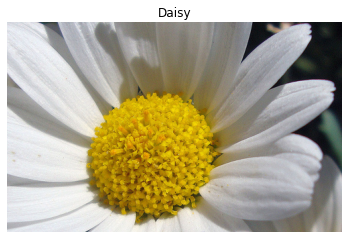

In [127]:
img = plt.imread("/content/drive/MyDrive/Proj.02-CNN flower classification/Daisy/10140303196_b88d3d6cec.jpg")
plt.imshow(img)
plt.title("Daisy")
plt.axis("off")
plt.show();

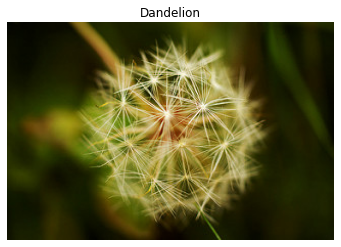

In [128]:
img = plt.imread("/content/drive/MyDrive/Proj.02-CNN flower classification/Dandelion/10043234166_e6dd915111_n.jpg")
plt.imshow(img)
plt.title("Dandelion")
plt.axis("off")
plt.show();

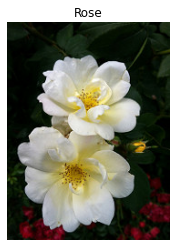

In [129]:
img = plt.imread("/content/drive/MyDrive/Proj.02-CNN flower classification/Rose/10090824183_d02c613f10_m.jpg")
plt.imshow(img)
plt.title("Rose")
plt.axis("off")
plt.show();

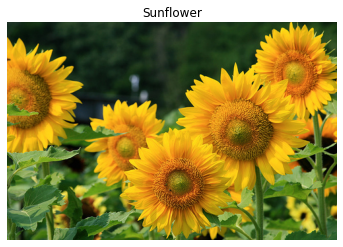

In [130]:
img = plt.imread("/content/drive/MyDrive/Proj.02-CNN flower classification/Sunflower/1008566138_6927679c8a.jpg")
plt.imshow(img)
plt.title("Sunflower")
plt.axis("off")
plt.show();

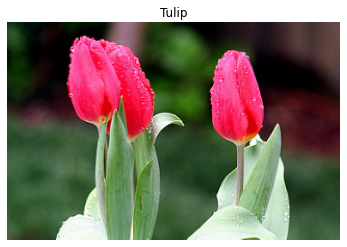

In [131]:
img = plt.imread("/content/drive/MyDrive/Proj.02-CNN flower classification/Tulip/100930342_92e8746431_n.jpg")
plt.imshow(img)
plt.title("Tulip")
plt.axis("off")
plt.show();

##Feteching all Dataset

In [132]:
dataset_url = '/content/drive/MyDrive/Proj.02-CNN flower classification'

##Define some parameters for the loader:

In [133]:
batch_size = 32
img_height = 180
img_width = 180

Let's use 80% of the images for training, and 20% for validation.

In [134]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4327 files belonging to 5 classes.
Using 3462 files for training.


In [135]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4327 files belonging to 5 classes.
Using 865 files for validation.


In [136]:
class_names = train_ds.class_names
print(class_names)

['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']


##Visualize the data
Here are the first nine images from the training dataset:

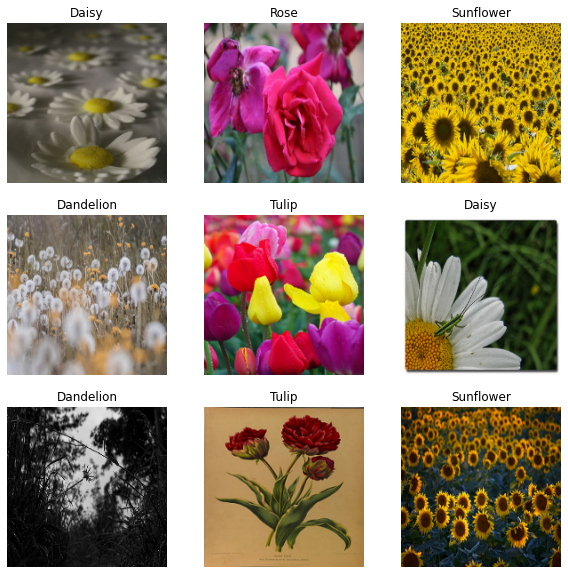

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [138]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

**Prefetching**

-> **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

-> **Dataset.prefetch** overlaps data preprocessing and model execution while training.

In [139]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [140]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [141]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9998003


#Creating the model

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [142]:
num_classes = 5

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#Compile the model

For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [143]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Model summary
View all the layers of the network using the model's Model.summary method:

In [144]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

#Training the model

In [145]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
109/109 [==============================] - 96s 873ms/step - loss: 1.2515 - accuracy: 0.4795 - val_loss: 1.1003 - val_accuracy: 0.5491
Epoch 2/10
109/109 [==============================] - 95s 867ms/step - loss: 0.9510 - accuracy: 0.6291 - val_loss: 0.9350 - val_accuracy: 0.6393
Epoch 3/10
109/109 [==============================] - 95s 872ms/step - loss: 0.7500 - accuracy: 0.7135 - val_loss: 0.9178 - val_accuracy: 0.6821
Epoch 4/10
109/109 [==============================] - 95s 871ms/step - loss: 0.5218 - accuracy: 0.8050 - val_loss: 1.2650 - val_accuracy: 0.6208
Epoch 5/10
109/109 [==============================] - 95s 868ms/step - loss: 0.3054 - accuracy: 0.8917 - val_loss: 1.2690 - val_accuracy: 0.6243
Epoch 6/10
109/109 [==============================] - 94s 863ms/step - loss: 0.1560 - accuracy: 0.9489 - val_loss: 1.3789 - val_accuracy: 0.6347
Epoch 7/10
109/109 [==============================] - 92s 842ms/step - loss: 0.1328 - accuracy: 0.9622 - val_loss: 1.5371 - val_ac

#Visualize training results
Create plots of loss and accuracy on the training and validation sets:

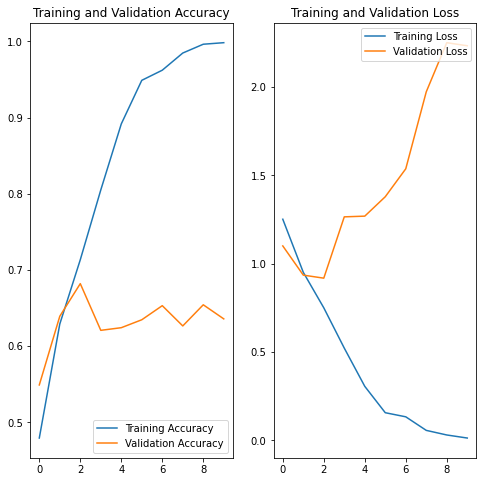

In [146]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

#Overfitting
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

#Data augmentation
Overfitting generally occurs when there are a small number of training examples. **Data augmentation** takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following **Keras preprocessing layers:** *tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom*. These can be included inside your model like other layers, and run on the GPU.

In [147]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

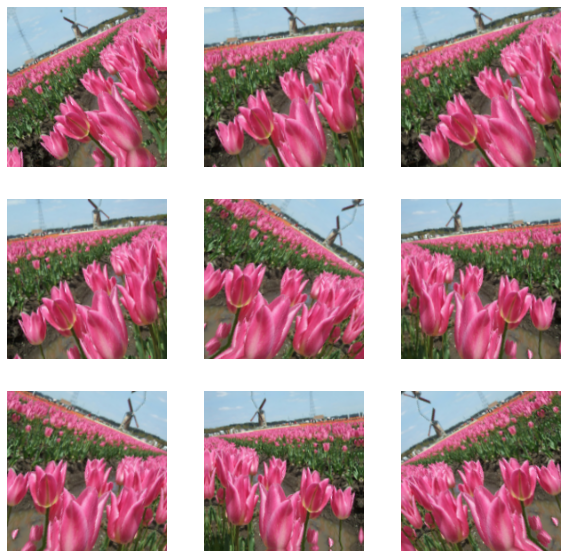

In [148]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as **0.1, 0.2, 0.4, etc**. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with **tf.keras.layers.Dropout** before training it using the augmented images:

In [149]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#Compile and train the model

In [150]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [151]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

**epochs:** An epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed.

In [152]:
#epochs=10
epochs = 12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
109/109 [==============================] - 108s 984ms/step - loss: 1.2831 - accuracy: 0.4535 - val_loss: 1.0737 - val_accuracy: 0.5884
Epoch 2/12
109/109 [==============================] - 108s 987ms/step - loss: 1.0332 - accuracy: 0.5895 - val_loss: 0.9567 - val_accuracy: 0.6335
Epoch 3/12
109/109 [==============================] - 106s 973ms/step - loss: 0.9419 - accuracy: 0.6225 - val_loss: 0.9480 - val_accuracy: 0.6416
Epoch 4/12
109/109 [==============================] - 108s 995ms/step - loss: 0.8863 - accuracy: 0.6496 - val_loss: 0.8944 - val_accuracy: 0.6566
Epoch 5/12
109/109 [==============================] - 107s 980ms/step - loss: 0.8394 - accuracy: 0.6696 - val_loss: 0.8465 - val_accuracy: 0.6832
Epoch 6/12
109/109 [==============================] - 106s 970ms/step - loss: 0.7881 - accuracy: 0.6944 - val_loss: 0.8679 - val_accuracy: 0.6636
Epoch 7/12
109/109 [==============================] - 108s 994ms/step - loss: 0.7578 - accuracy: 0.7057 - val_loss: 0.8477 -

#Visualize training results
After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

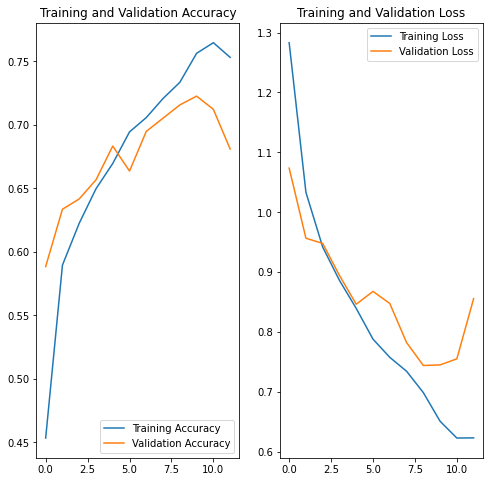

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Predict on new data
Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

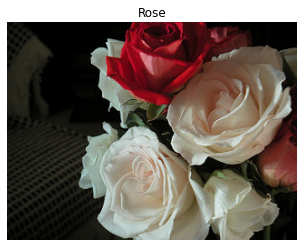

This image most likely belongs to Rose with a 73.37 percent confidence.


In [154]:
Rose_pic = "/content/drive/MyDrive/Proj.02-CNN flower classification/Rose/1392579828_ab5a139052.jpg"


img = tf.keras.utils.load_img(
    "/content/drive/MyDrive/Proj.02-CNN flower classification/Rose/102501987_3cdb8e5394_n.jpg", target_size=(img_height, img_width)
)

img_test = plt.imread("/content/drive/MyDrive/Proj.02-CNN flower classification/Rose/102501987_3cdb8e5394_n.jpg")
plt.imshow(img_test)
plt.title("Rose")
plt.axis("off")
plt.show();

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

*******Here percent is the accuracy to predict the image.*******

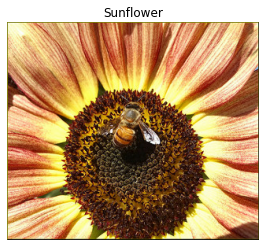

This image most likely belongs to Sunflower with a 59.08 percent confidence.


In [155]:
img = tf.keras.utils.load_img(
    "/content/drive/MyDrive/Proj.02-CNN flower classification/Sunflower/10386525005_fd0b7d6c55_n.jpg", target_size=(img_height, img_width)
)

img_test = plt.imread("/content/drive/MyDrive/Proj.02-CNN flower classification/Sunflower/10386525005_fd0b7d6c55_n.jpg")
plt.imshow(img_test)
plt.title("Sunflower")
plt.axis("off")
plt.show();

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

#Pickle model

In [156]:
import pickle

In [157]:
file = score
fileName = "Project_02.pkl"
fileObj = open(fileName, 'wb')   # wb for write
pickle.dump(file, fileObj)

fileObj.close()  #file close

############END OF CODE#############